### Hacemos lo mismo que en analisis de barra3, pero recalculamos el lbar con el phi

# Analisis de la barra

In [4]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Longitud de la barra

In [18]:
import h5py
import rotation as rot
import time_conversion as tiempo
import barstrength as strng
import matplotlib.gridspec as gridspec
from __future__ import unicode_literals

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True

#Parámetros cosmológicos
#--------------------------------------------------------------------------
h=0.732
G = 4.299e-6
a0=1.
H0 = h*100
omega_lambda=0.716
omega_matter=0.1277/(h**2.)
omega0 = omega_lambda + omega_matter
#---------------------------------------------------------------------------

aa = np.loadtxt('/home/ornela/python/ornella/redshift_outputs.txt')
aexp = aa[:,2]

snapshot=range(496,236,-1) #SNAPSHOTS

for isnap in snapshot:
    snap = h5py.File('/home/ornela/python/ornella/outputs_1/snap_'+str('%03d'%isnap)+'.h5py', 'r')

    cm   = snap['subhalo_000/Center'].value
    r200 = snap['subhalo_000/R200'].value
    pstr = snap['subhalo_000/Str/Coordinates'].value
    mstr = snap['subhalo_000/Str/Masses'].value
    vel  = snap['subhalo_000/Str/Velocities'].value
  
    z     = a0/aexp[isnap] - 1.
    Ht    = H0*np.sqrt(omega_lambda+(1-omega0)*(1+z)**2+omega_matter*(1+z)**3)
    time  = tiempo.conv(z, h, omega_lambda, omega_matter)

#paso las coordenadas al centro de la galaxia y paso a coordenadas físicas
    xstr = (pstr[:,0]-cm[0])*aexp[isnap]/h
    ystr = (pstr[:,1]-cm[1])*aexp[isnap]/h
    zstr = (pstr[:,2]-cm[2])*aexp[isnap]/h
    r    = np.sqrt(xstr**2+ystr**2+zstr**2)
    
#paso las velocidades a unidades físicas
    v_x = vel[:,0] *np.sqrt(aexp[isnap]) + Ht *xstr/1000.
    v_y = vel[:,1] *np.sqrt(aexp[isnap]) + Ht *ystr/1000.
    v_z = vel[:,2] *np.sqrt(aexp[isnap]) + Ht *zstr/1000.

    mstr = mstr/h     #masa a unidades físicas

    r200 = r200*aexp[isnap]/h #radio virial a unidades fisicas

    rgal = 0.15*r200          #defino el radio de la galaxia
#     print 'rgal=', rgal
    
    limit = np.where(r<rgal)         #hago un límite de los r dentro de rgal
    r_sort = np.sort(r[limit])       #acomodo los r de menor a mayor
    r_indice = np.argsort(r[limit])  #saco los argumentos de r acomodados de menor a mayor

    Mc_str = cumsum(mstr[limit][r_indice])  #masa acumulada en cada radio dentro de rgal
    Mgal = Mc_str[-1]  #masa total de la galaxia

#Calculo de los radios a 50% y 90% la masa de la galaxia
#-----------------------------------------------------------------------
    razon = Mc_str/Mgal 
    noventa, = np.where(razon < 0.9)
    cincuenta, = np.where(razon < 0.5)

    r90 = r_sort[noventa][-1]   #radio a 90% la masa
    r50 = r_sort[cincuenta][-1] #radio a 50% la masa
    
#     print 'r50=', r50
#     print 'r90=', r90
#     print r'log(M+/Msol)=', log10(Mgal*1e10)

#componentes de la velocidad del centro de masa
    veloc, = np.where(r < r50)
    
    vxcm = sum(mstr[veloc]*v_x[veloc])/sum(mstr[veloc])
    vycm = sum(mstr[veloc]*v_y[veloc])/sum(mstr[veloc])
    vzcm = sum(mstr[veloc]*v_z[veloc])/sum(mstr[veloc])

#velocidades de las estrellas respecto del centro de masa de la galaxia
    vx = v_x - vxcm
    vy = v_y - vycm
    vz = v_z - vzcm


#calculo el raux
#     raux = 2*r50
#------------------------------------------------------------------------------------
    dd = range(496,300,-1)
    dd.remove(428)
    if isnap in dd:
        raux = 2*r50
    elif (isnap == 428) or ((isnap < 301) & (isnap > 283)):
        raux = r50
    elif (isnap > 271) & (isnap < 284):
        raux = 0.75
    elif isnap < 272:
        raux = 0.5
#-----------------------------------------------------------------------------------

#hago la rotación de las coordenadas respecto del momento angular    
    e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(mstr,xstr,ystr,zstr,vx,vy,vz,raux)

    xn = e1x*xstr + e1y*ystr + e1z*zstr
    yn = e2x*xstr + e2y*ystr + e2z*zstr
    zn = e3x*xstr + e3y*ystr + e3z*zstr
    vxn = e1x*vx + e1y*vy + e1z*vz
    vyn = e2x*vx + e2y*vy + e2z*vz
    vzn = e3x*vx + e3y*vy + e3z*vz
    
    
    corte1,=np.where(r<rgal)
    
#     if isnap in range(256,272):
#         corte2 = np.where(r<0.75)
#     else:
#         corte2 = np.where(r<raux)

    corte1, = np.where(r<4*r50)
    corte2, = np.where(r<raux)
    corte3, = np.where(r<2*r50)

    A2, phi, rbin = strng.a2(mstr[corte3], xn[corte3], yn[corte3], 30)
    A2max, rmax, phimax = strng.a2max(mstr[corte3], xn[corte3], yn[corte3], 20)

    
# med = mean(phi[1:5])

    phii = phi - phimax

    for i in range(1,len(phii)-2):
        if ((phii[i]<np.arcsin(0.3)) & (phii[i]>-np.arcsin(0.3)) & (phii[i+1]>np.arcsin(0.3))):
            if ((phii[i+2]>np.arcsin(0.3)) | (phii[i+2]<-np.arcsin(0.3))):
                pend = (phii[i+1]-phii[i])/(rbin[i+1]-rbin[i])
                ordenada = phii[i]- pend*rbin[i]
                lbar = (np.arcsin(0.3) - ordenada)/pend
                break
        elif ((phii[i]>-np.arcsin(0.3)) & (phii[i]<np.arcsin(0.3)) & (phii[i+1]<-np.arcsin(0.3))):
            if ((phii[i+2]>np.arcsin(0.3)) | (phii[i+2]<-np.arcsin(0.3))):
                pend = (phii[i+1]-phii[i])/(rbin[i+1]-rbin[i])
                ordenada = phii[i]- pend*rbin[i]
                lbar = (-np.arcsin(0.3) - ordenada)/pend
                break
#     print lbar

    #Guargamos los parámetros en distintos archivos
#----------------------------------------------------------------------------------
    archivo1 =  open('/home/ornela/python/SAN/lbar_time3.dat','a')
    archivo1.write(str('%03d'% isnap) +'\t'+
               str('%12.6f'% time) +'\t'+
               str('%12.6f'% lbar) +'\n')
    archivo1.close()
#------------------------------------------------------------------------------------



In [6]:
import pandas

/home/ornela/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:27: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version


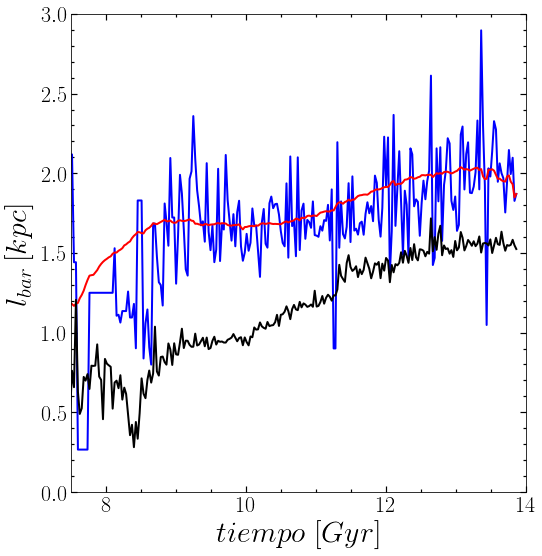

In [8]:
from __future__ import unicode_literals

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True

cm = np.loadtxt('/home/ornela/python/barras/lbar_time.dat')
time0 = cm[:,1]
lbar0 = cm[:,2]

# cm = np.loadtxt('/home/ornela/python/SAN/lbar_time3.dat')
# time = cm[:,1]
# lbar = cm[:,2]

cm = np.loadtxt('/home/ornela/python/SAN/lbar_time2.dat')
time1 = cm[:,1]
lbar1 = cm[:,2]

# cm = np.loadtxt('/home/ornela/python/SAN/lbar_time.dat')
# time2 = cm[:,1]
# lbar2 = cm[:,2]

# def movingaverage(interval,window_size):
#     window = numpy.ones(int(window_size))/float(window_size)
#     return numpy.convolve(interval, window, 'same')
# lbar_mean = movingaverage(lbar1,30)

lbar_mean=pandas.rolling_mean(lbar1, 50, min_periods=1)

fig=plt.figure(1, figsize=(8,8))
fig.subplots_adjust(bottom=0.12, left =0.16, right = 0.95, top = 0.95)
ax=fig.add_subplot(111)

# ax.plot(time,lbar,'-', lw=2, color='r')
ax.plot(time1,lbar1,'-', lw=2, color='b')
ax.plot(time1,lbar_mean, lw=2, color='r')
# ax.plot(time2,lbar2,'-', lw=2, color='g')
ax.plot(time0,lbar0,'-', lw=2, color='k')
ax.set_xlim(7.5,14)
ax.set_ylim(0,3)
# ax.spines['bottom'].set_color('w')
# ax.spines['top'].set_color('w')
# ax.spines['left'].set_color('w')
# ax.spines['right'].set_color('w')
ax.minorticks_on()
ax.tick_params( labelsize=22)#, colors='lightgray')
ax.tick_params('both', length=3, width=1.2,which='minor', direction='in', right='on',top='on')#,colors='w')
ax.tick_params('both', length=6, width=1.2,which='major', direction='in', right='on',top='on')#,colors='w')  
# ax.set_facecolor('silver')
# ax.grid(color='w',linestyle=':',which='major')
#ax.grid(color='lightgray',linestyle=':',which='minor')
ax.set_xlabel(r'$tiempo$ $[Gyr]$', fontsize=30)#, color='lightgray')
ax.set_ylabel(r'$l_{bar}\:[kpc]$',fontsize=30)#, color='lightgray')
# fig.savefig('/home/ornela/Dropbox/Presentaccion_AAA/lbar_time.png', dpi = 100)
plt.show()

1.6926029203


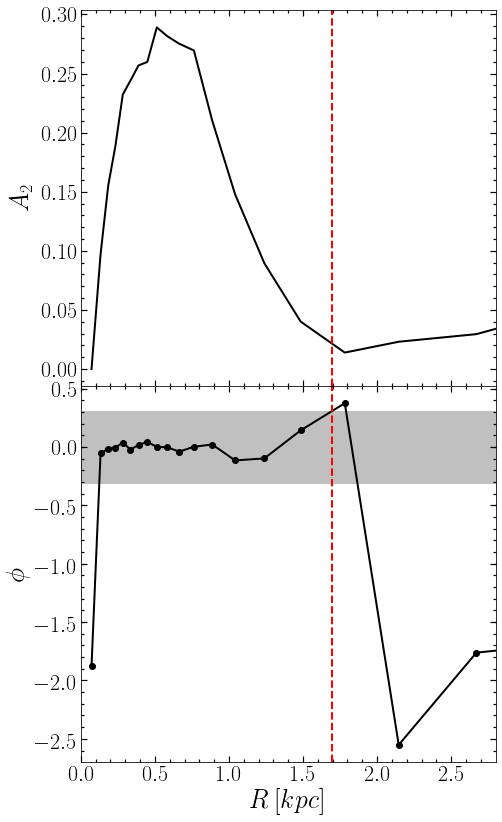

1.34981472713


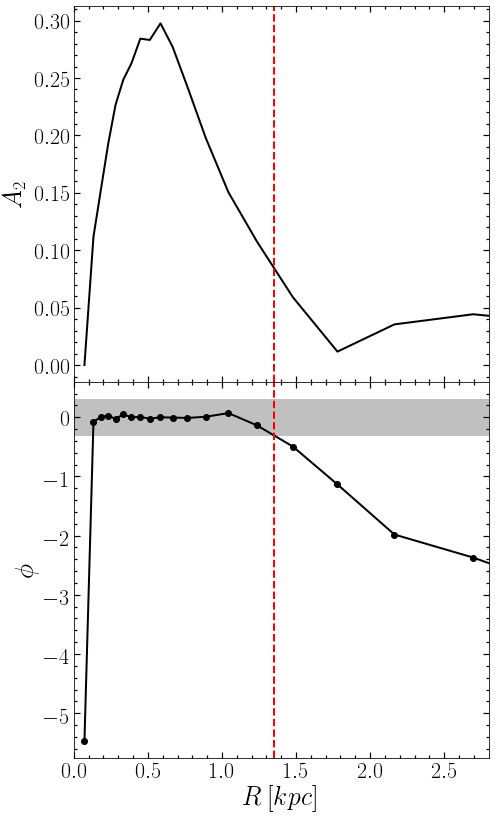

1.51607642896


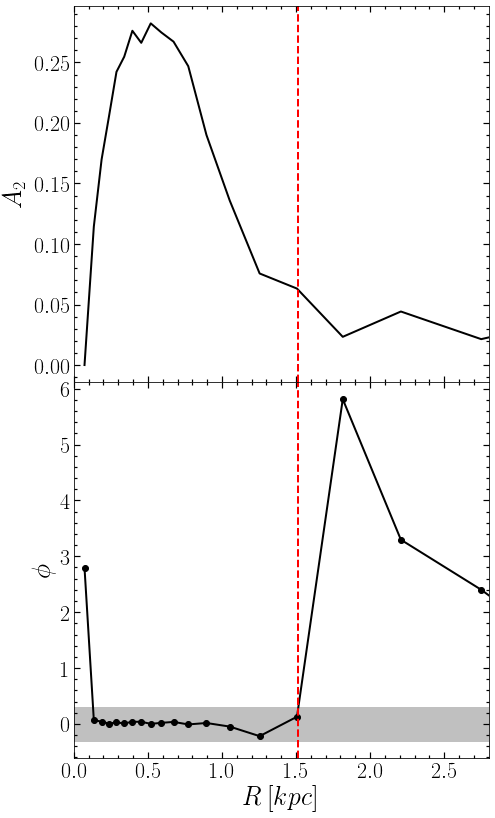

1.67050475237


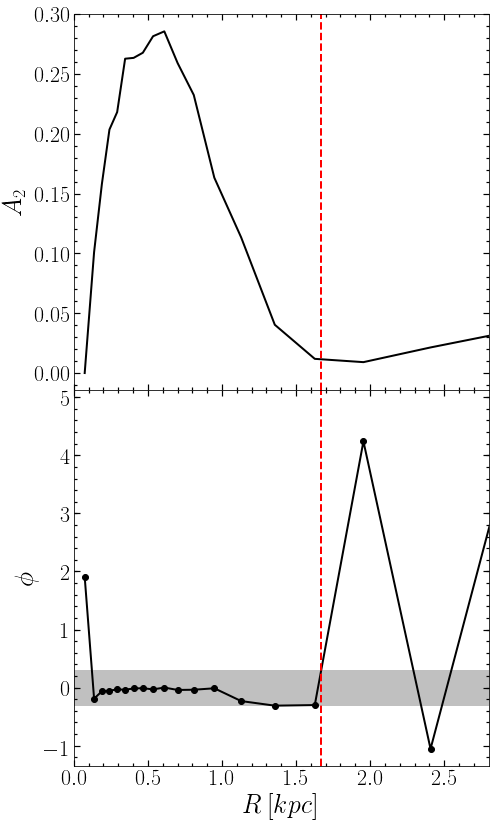

1.67216647866


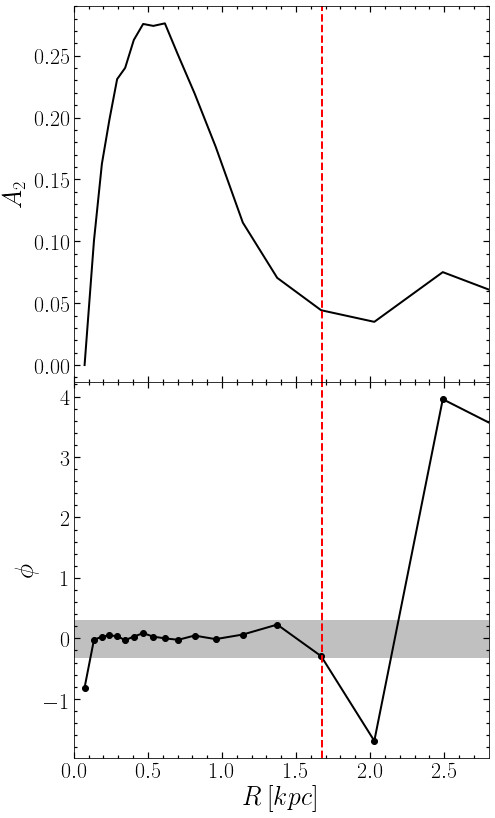

1.77914551288


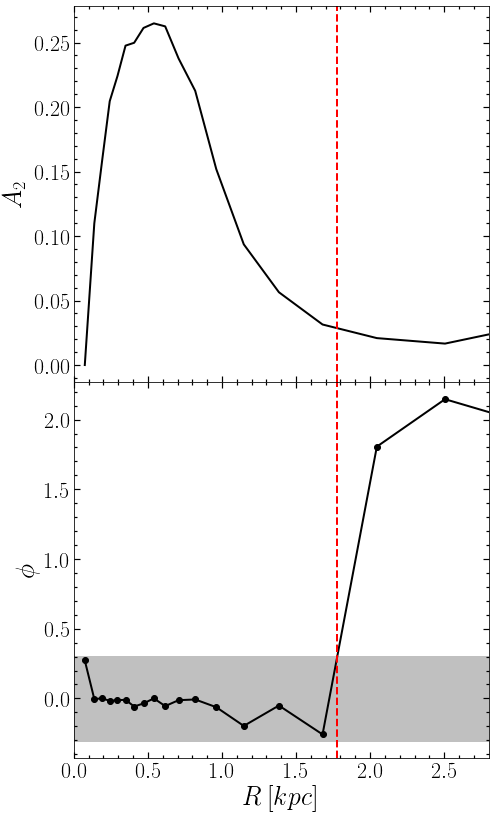

1.56393318616


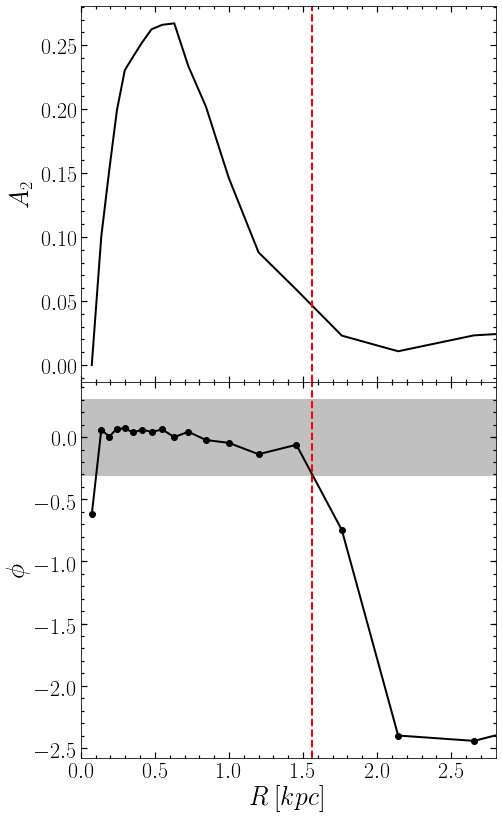

1.51359554358


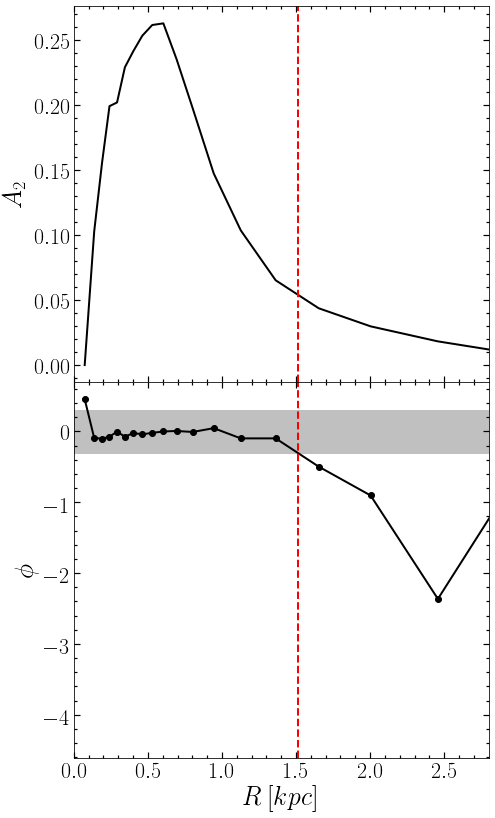

1.61980046596


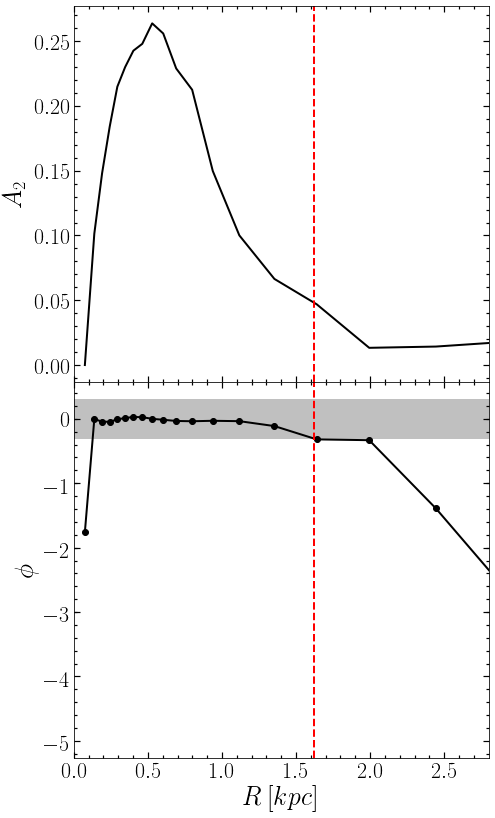

1.5016708128


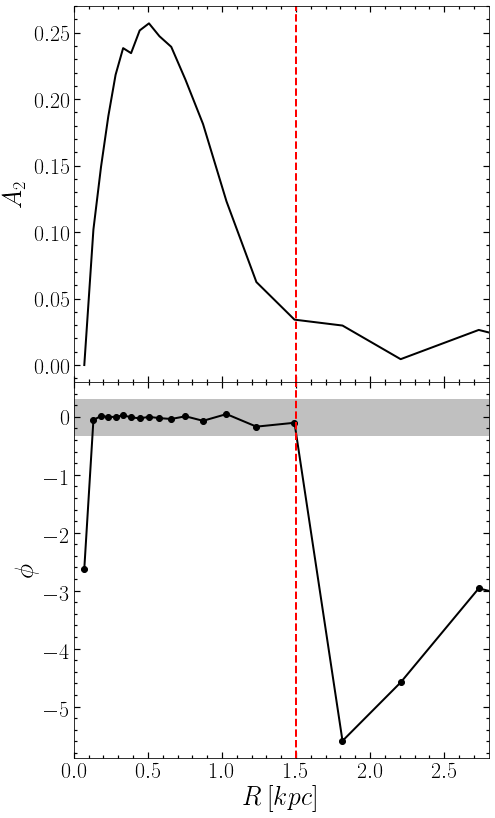

1.45082773639


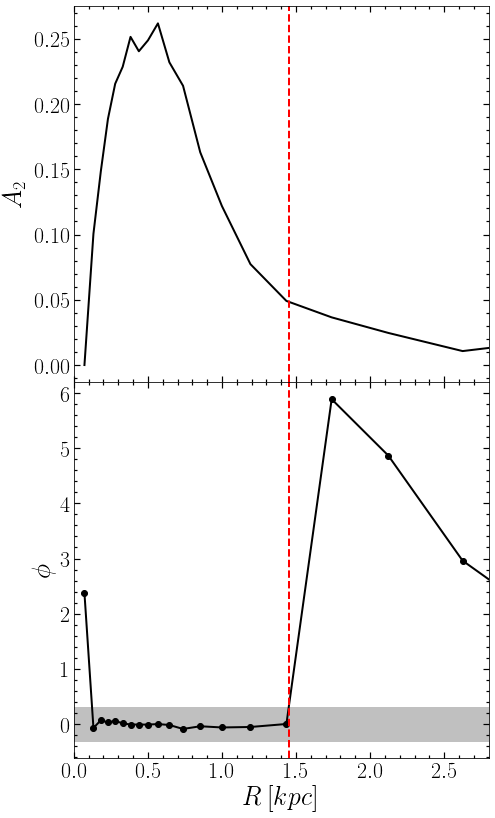

1.54196370755


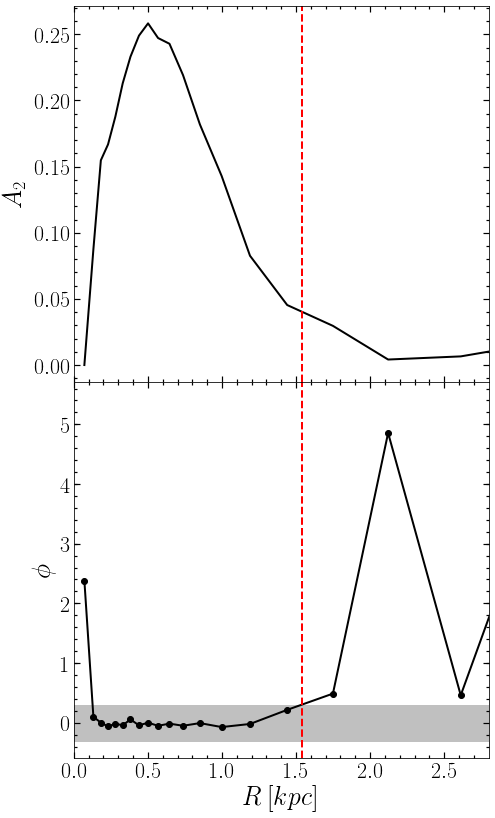

1.8275576742


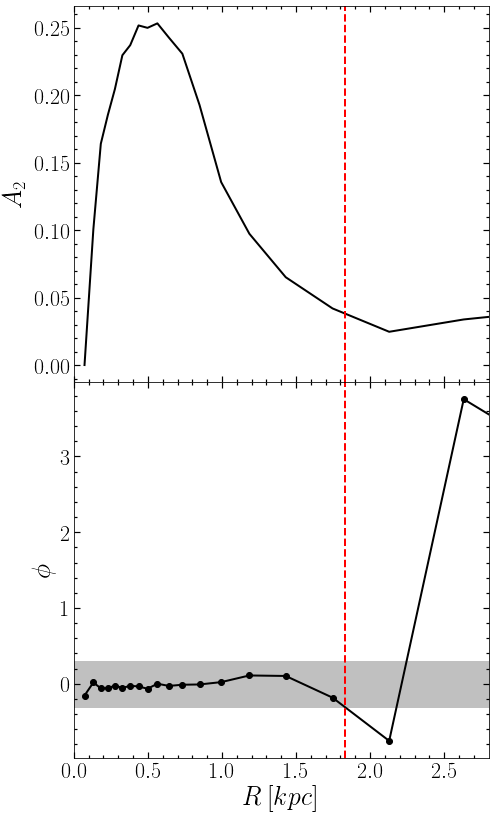

1.75607513176


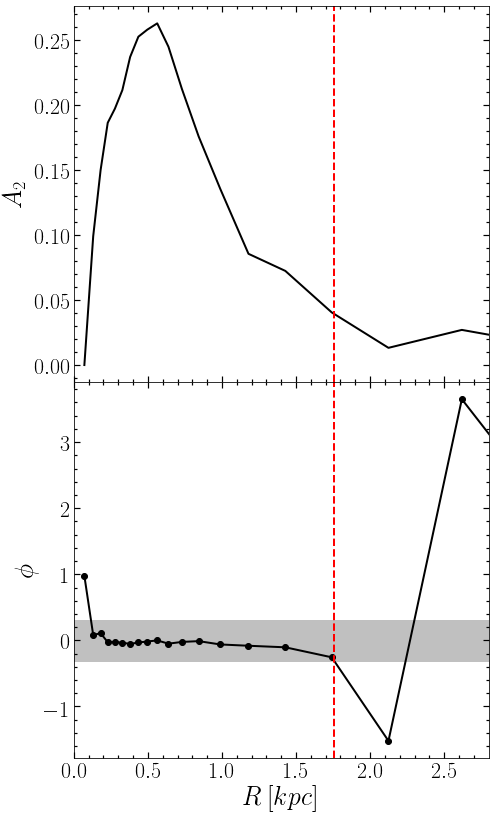

1.54168042871


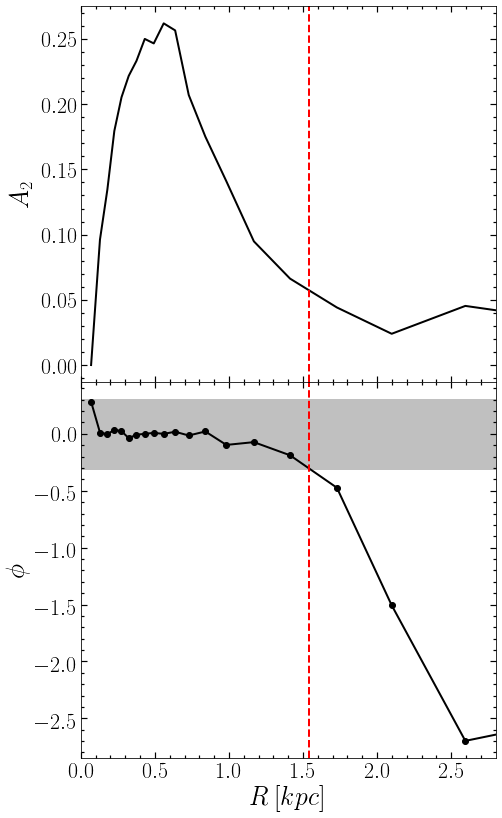

1.74335104069


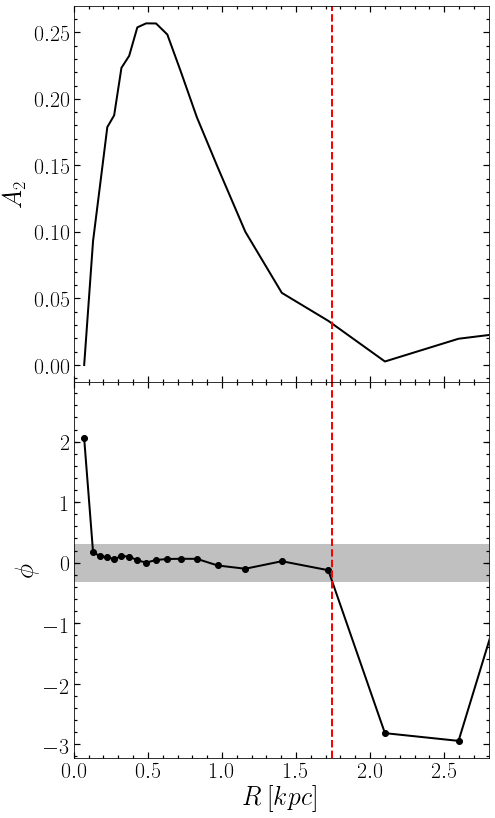

1.57721809086


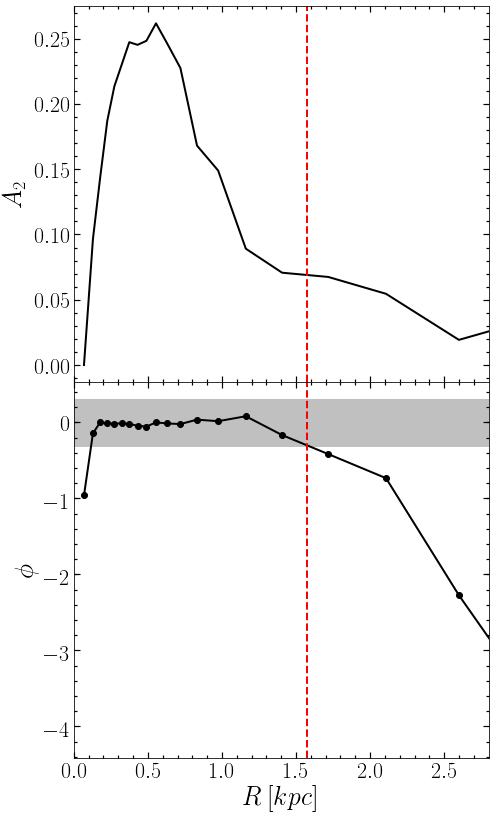

1.70393654682


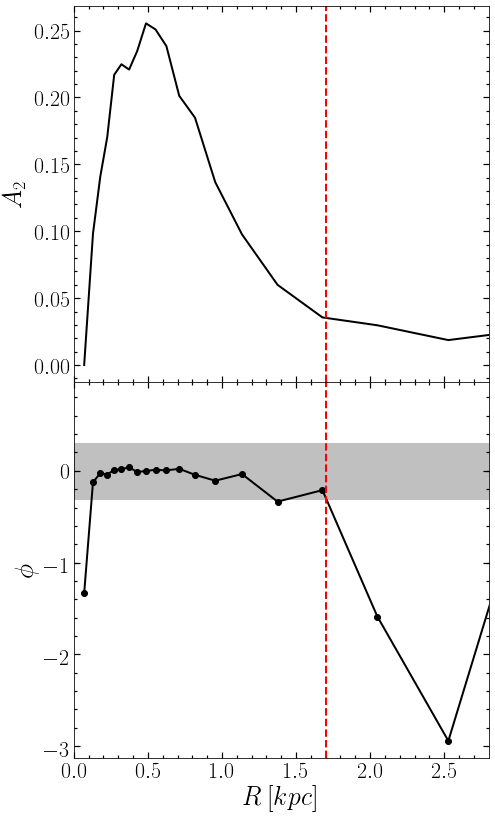

1.83234368504


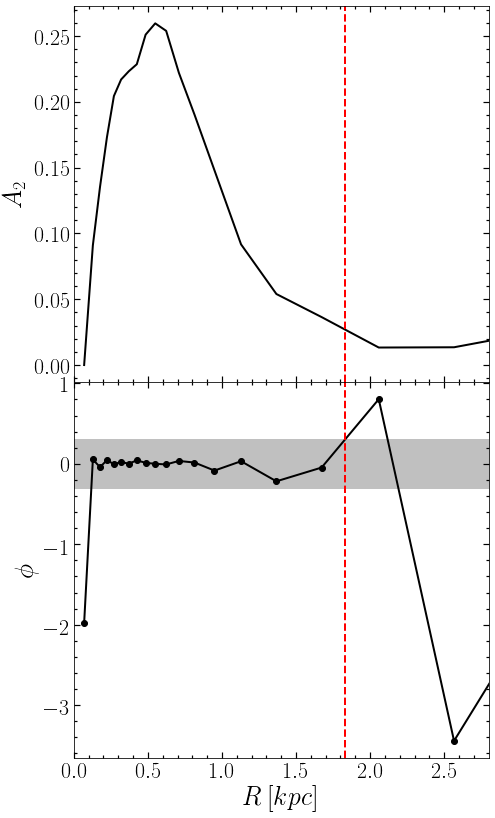

2.11486341824


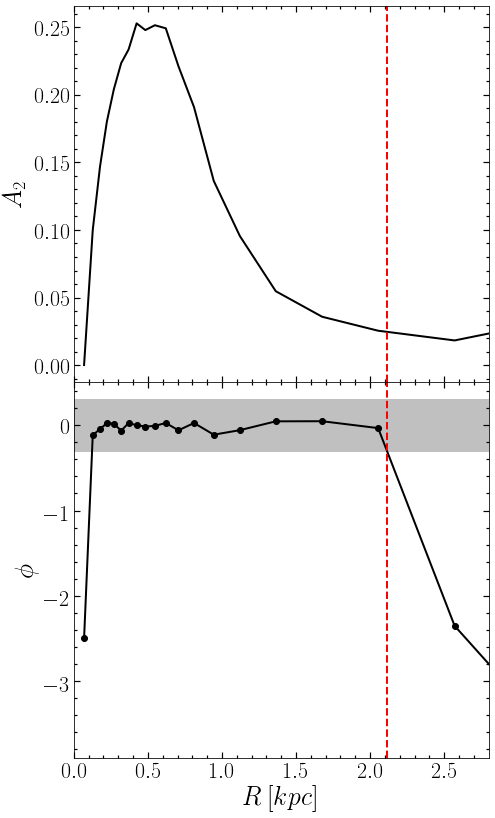

1.64677228032


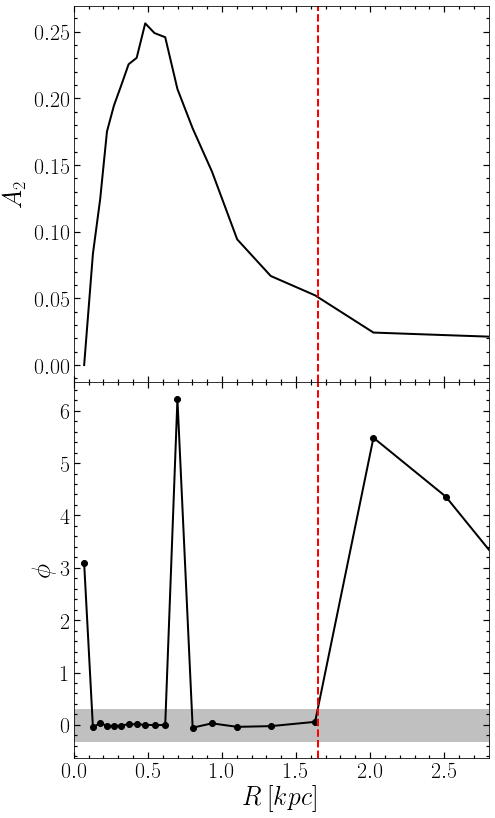

1.67704299219


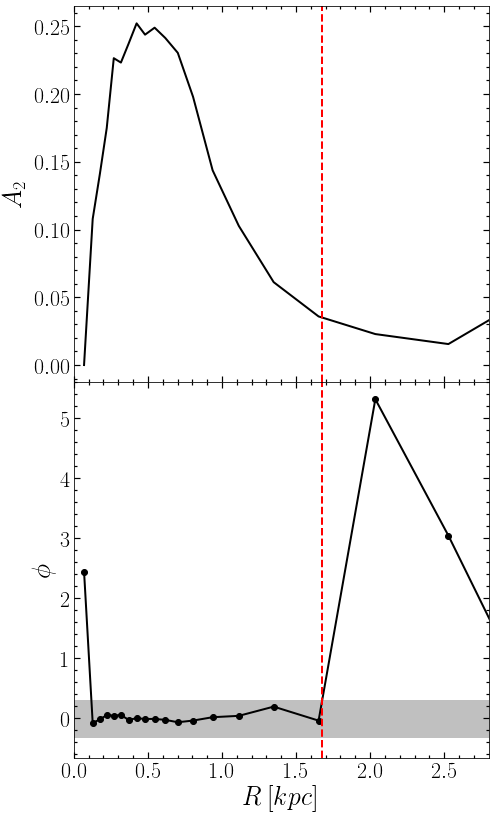

1.44918067817


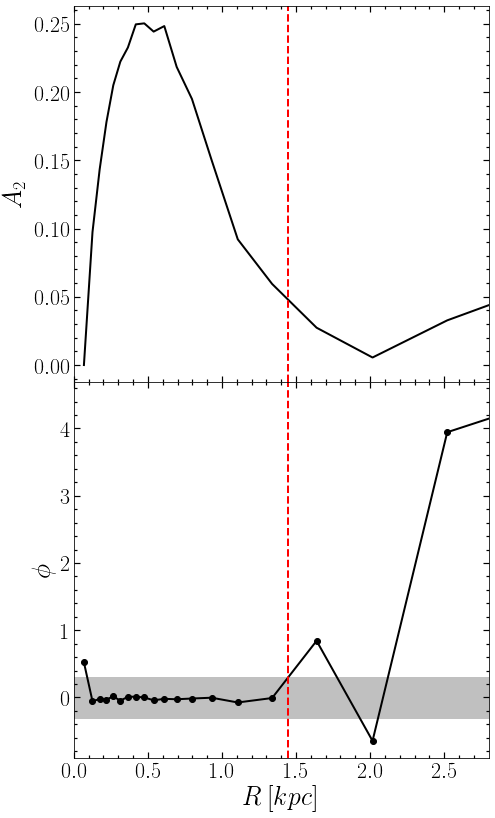

2.02812538488


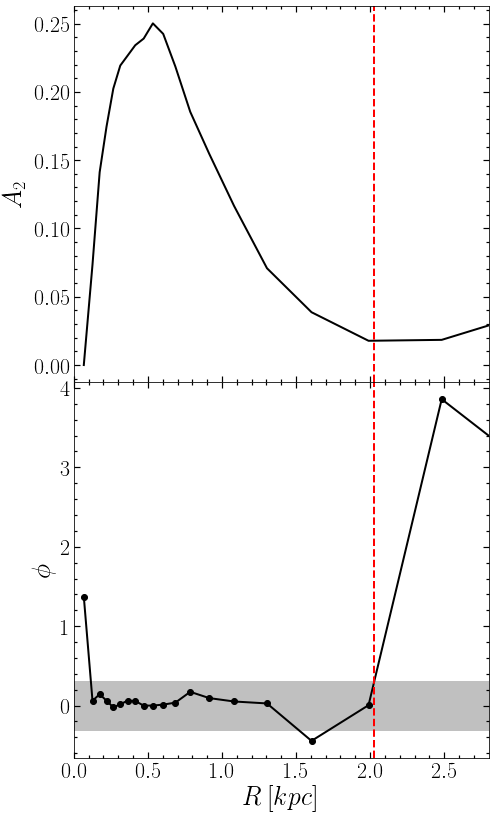

1.52089707347


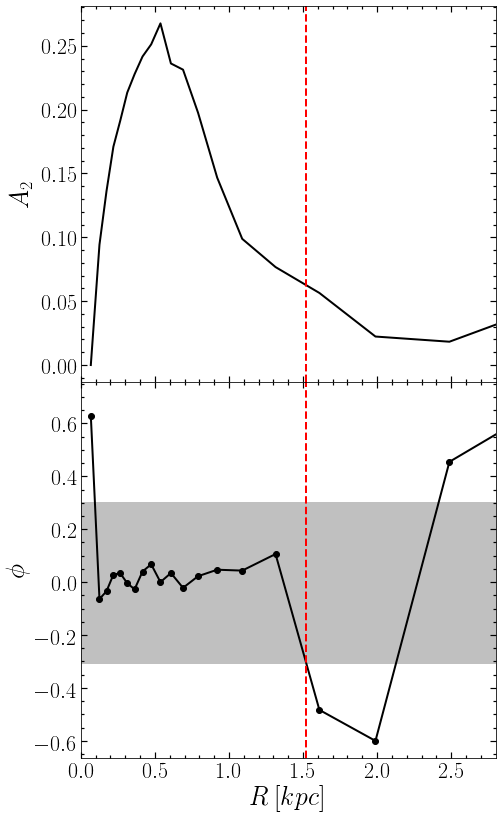

1.44207381849


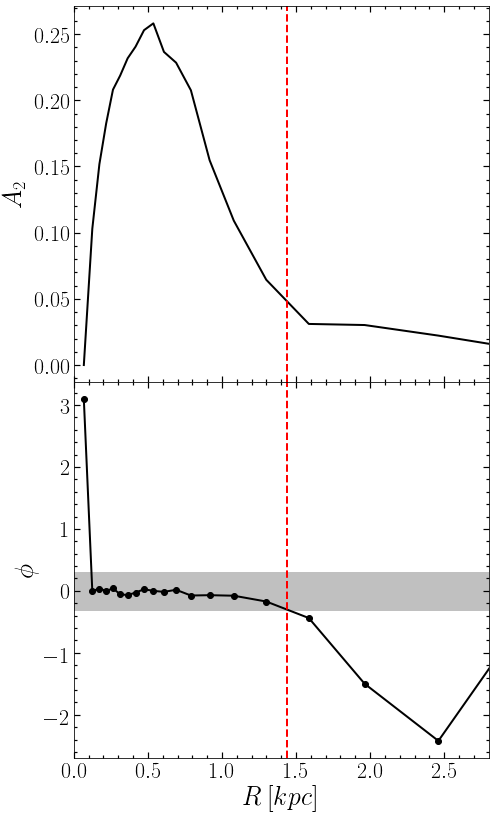

1.67259183166


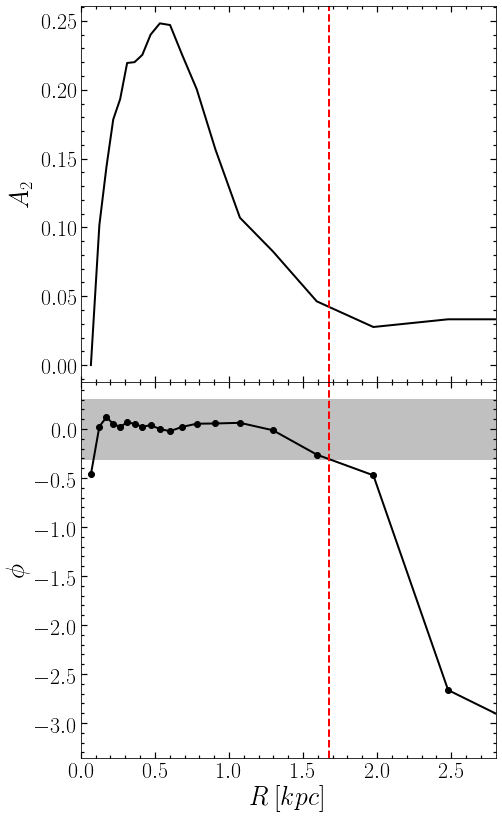

1.51743529921


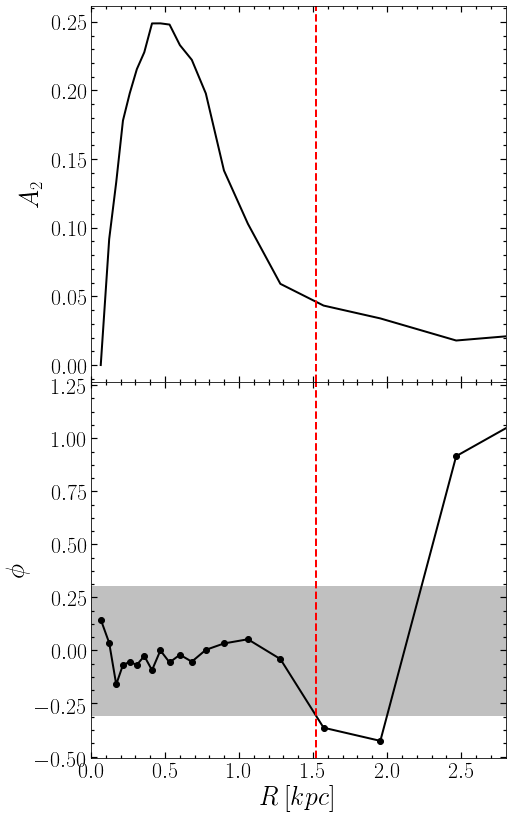

1.63330211852


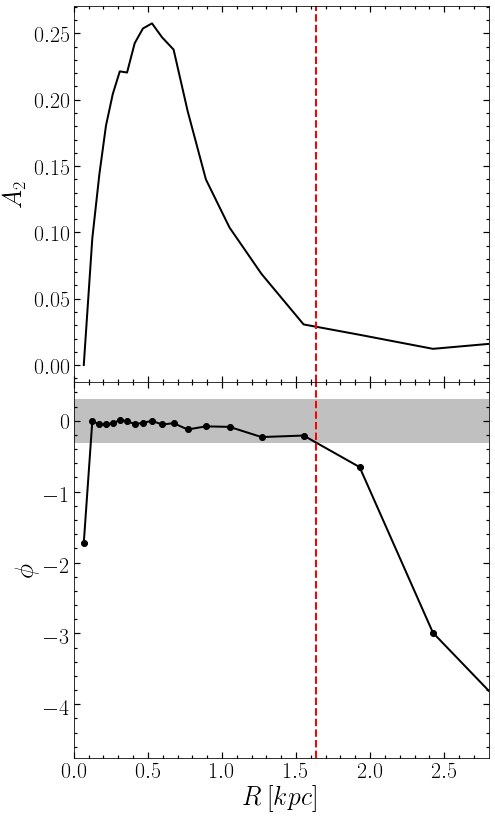

2.06331864124


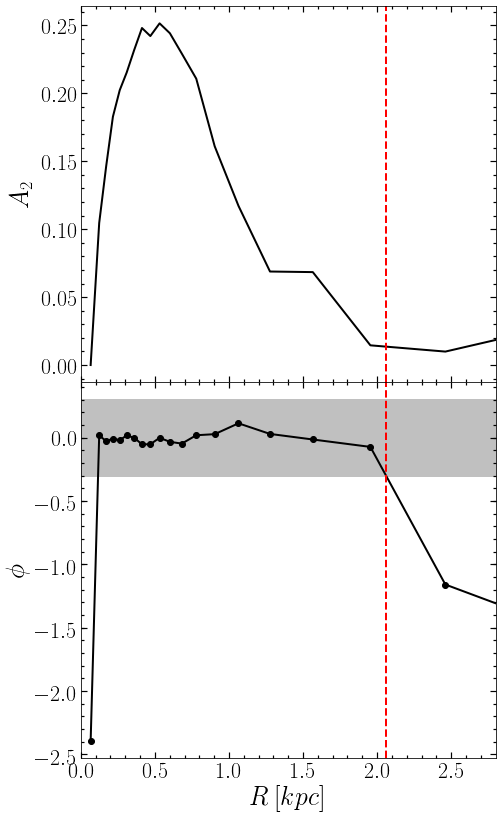

1.57067809255


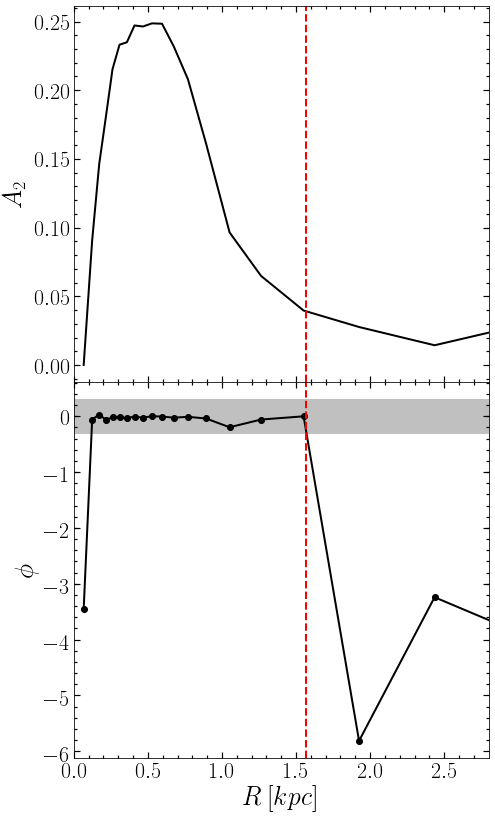

1.69842084721


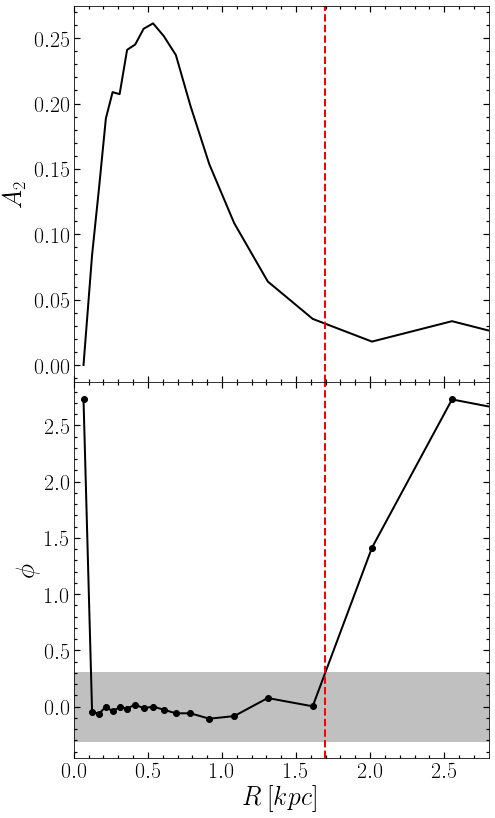

1.6730307965


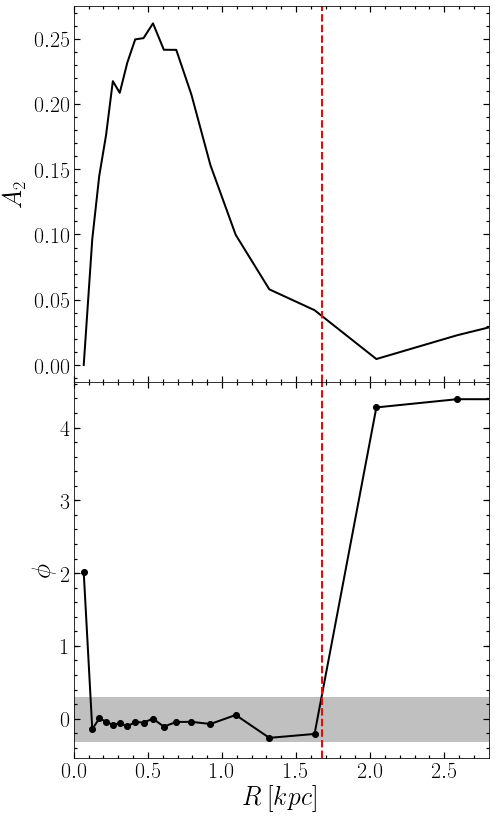

1.79273291532


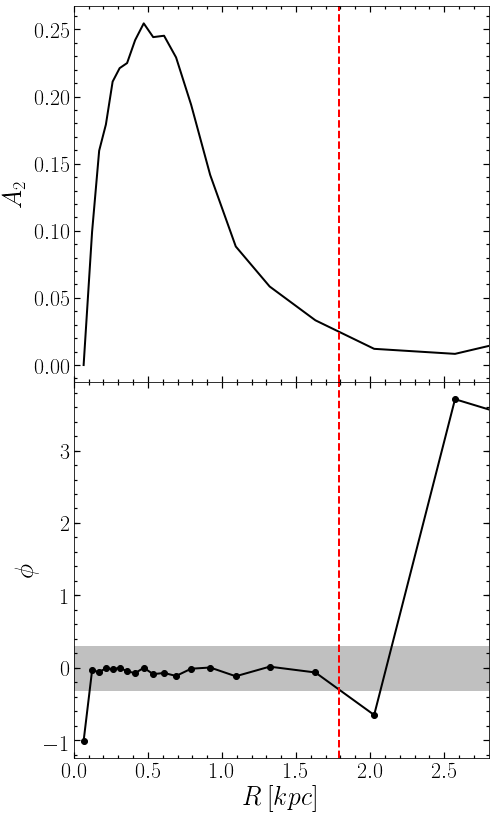

1.89286482606


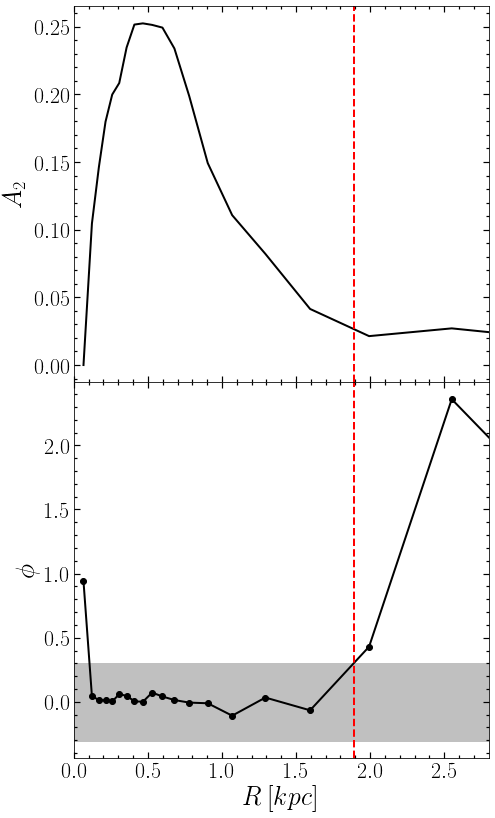

2.09049514634


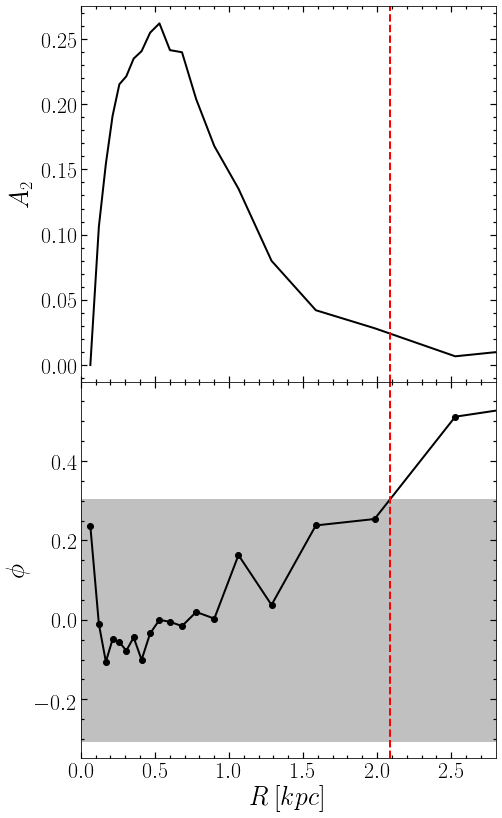

2.3587498455


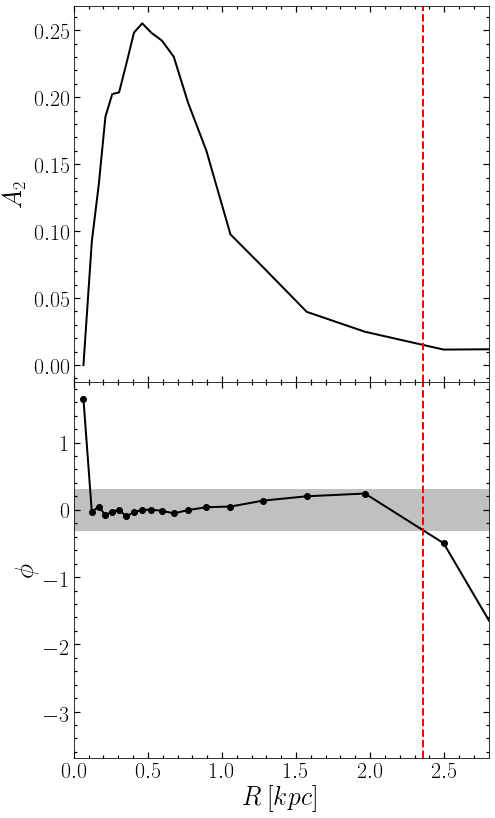

2.01219561097


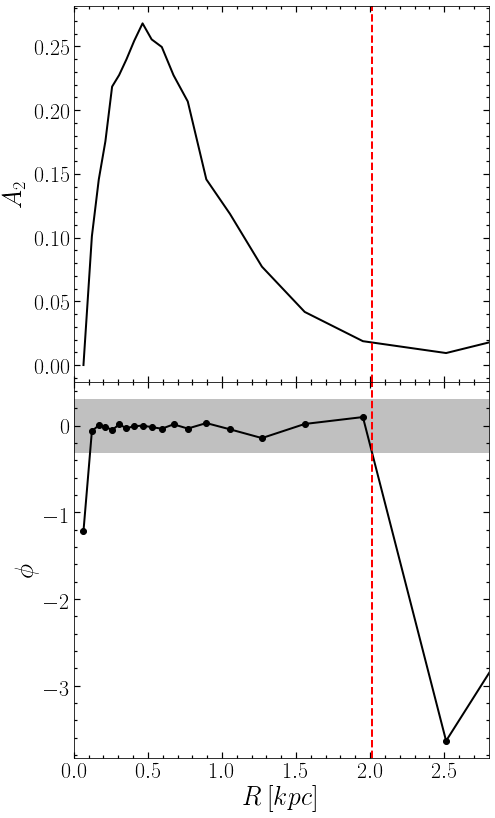

1.96539291229


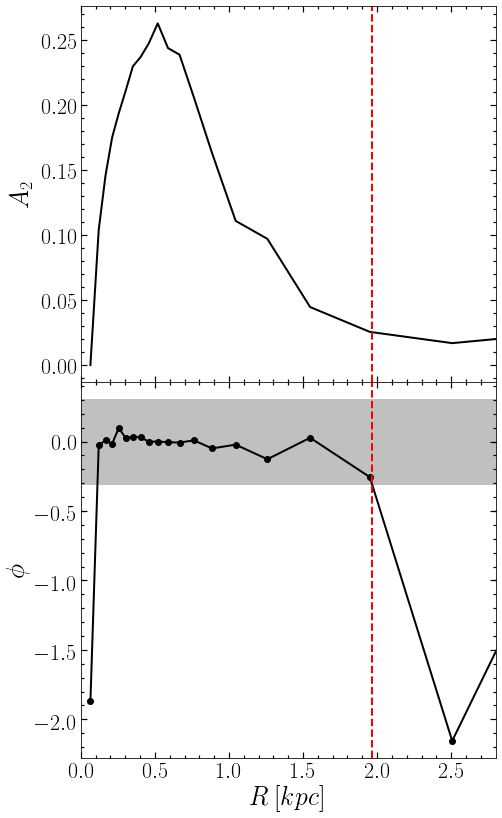

1.35768895099


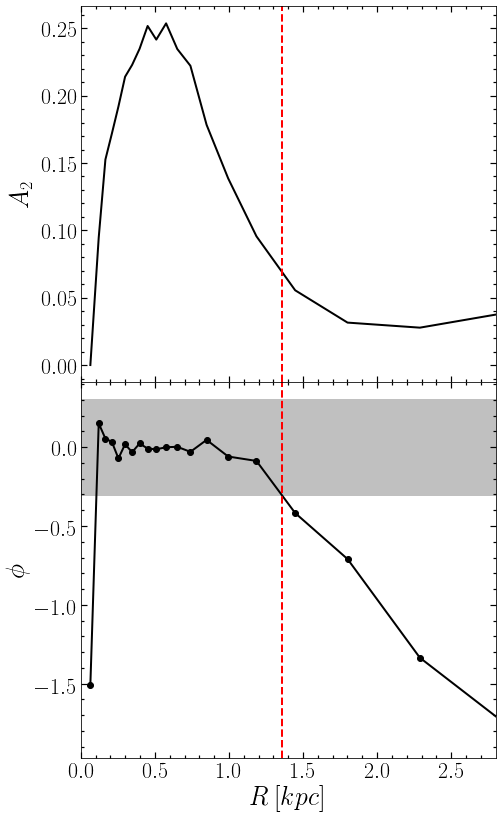

1.39769401124


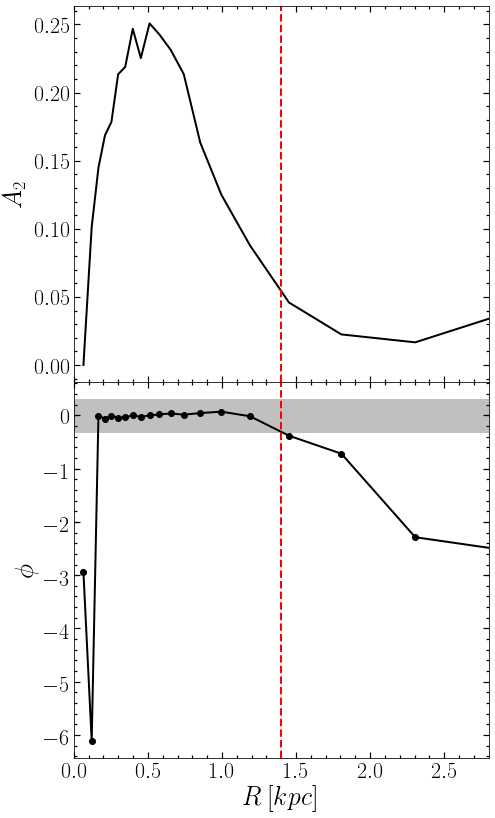

1.64686092068


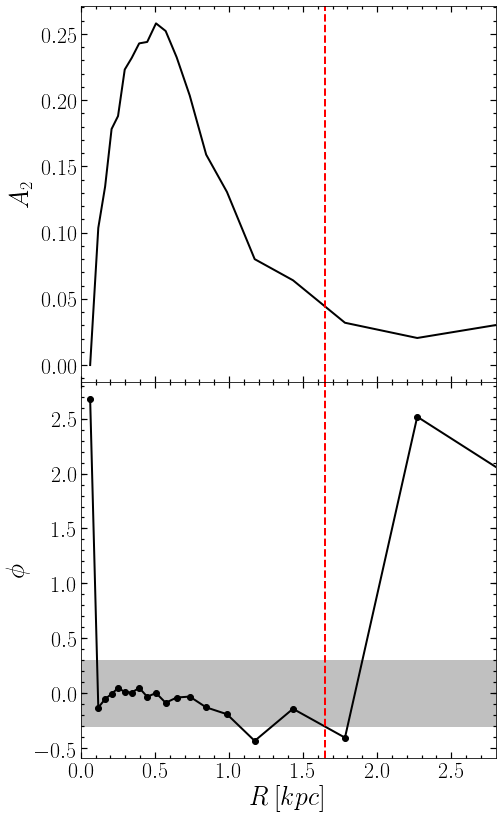

1.87291959773


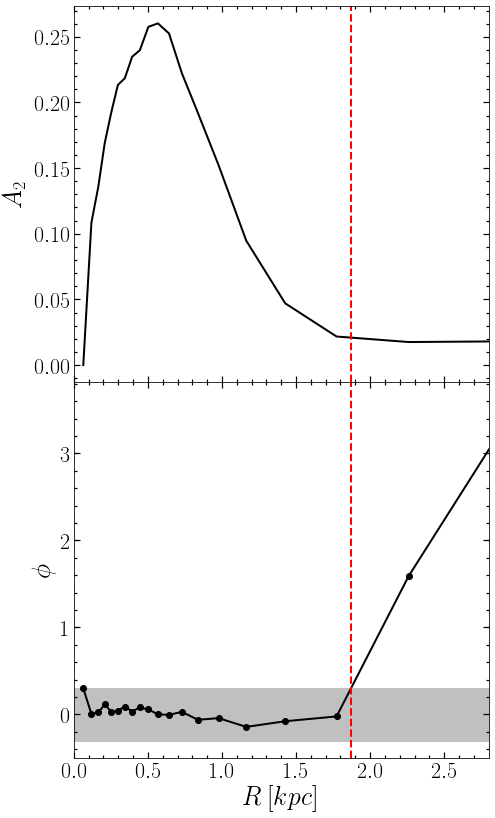

1.99032270406


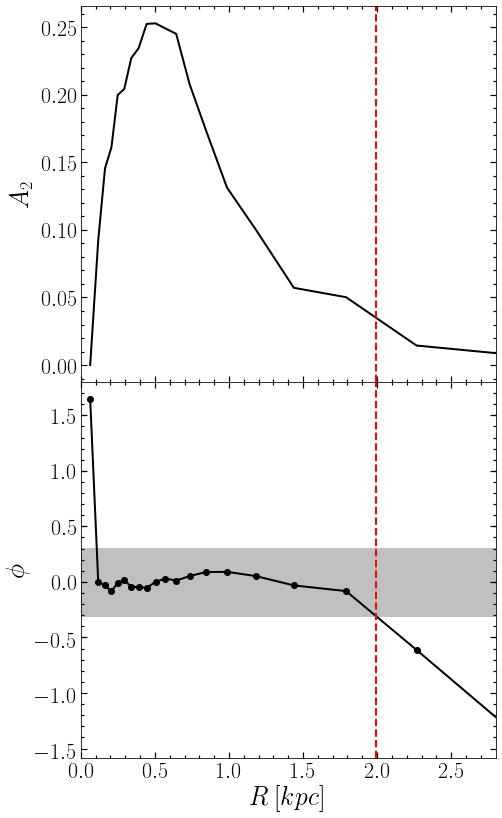

1.60658468365


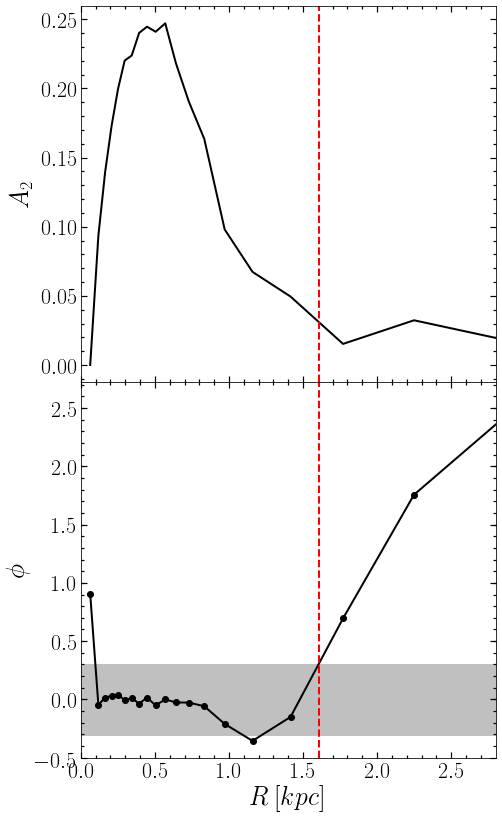

1.30709811834


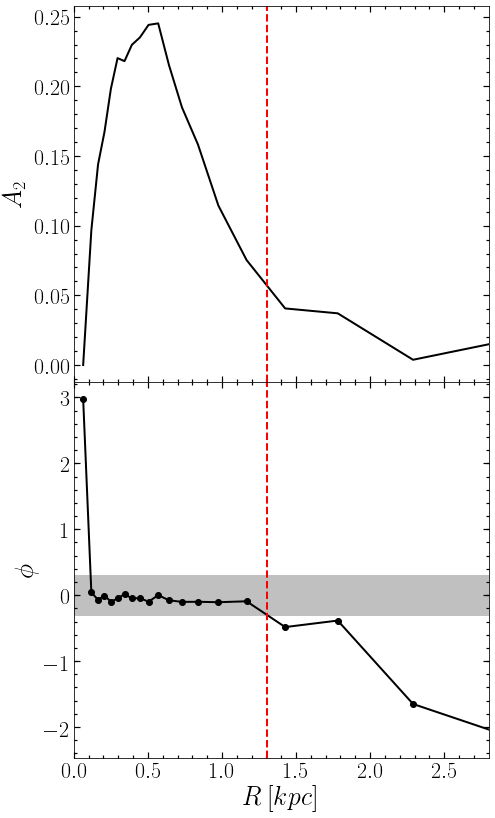

1.7224566829


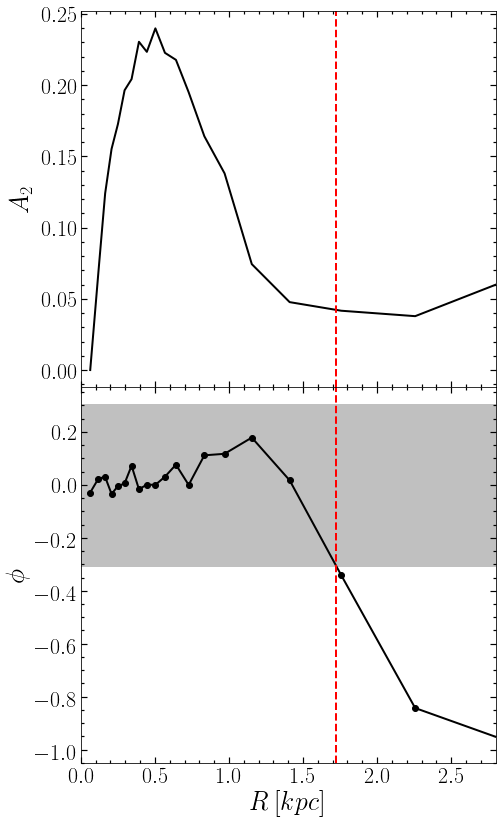

1.7224566829


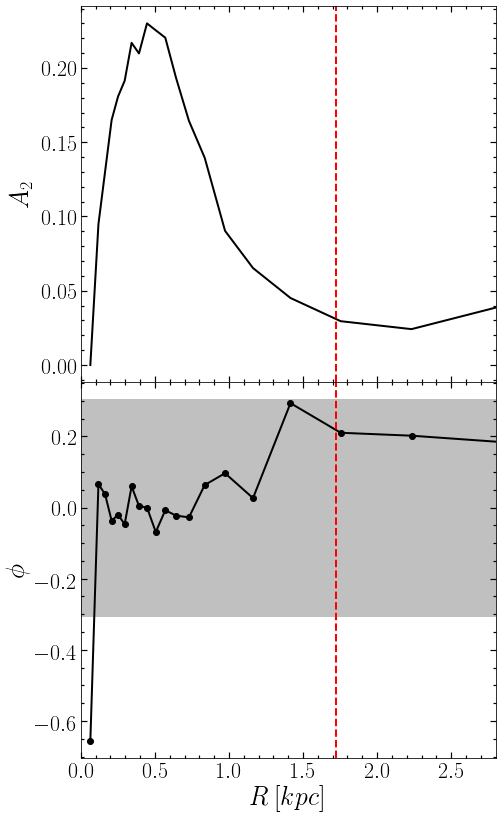

2.09579436846


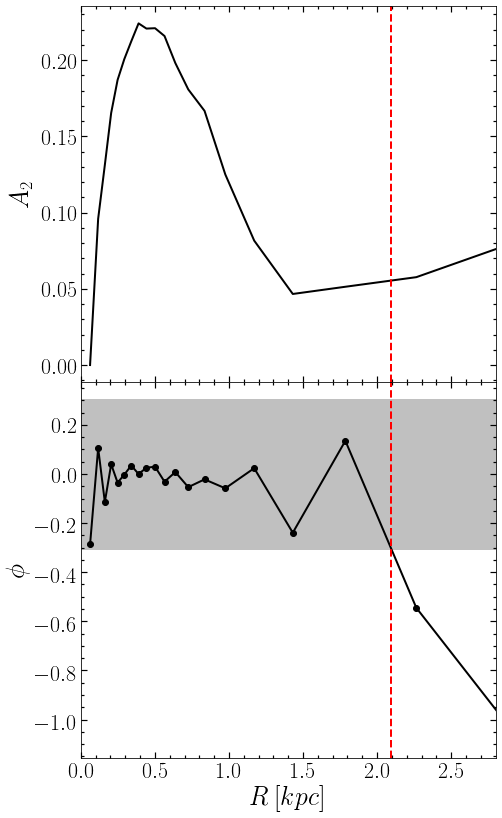

1.54530833061


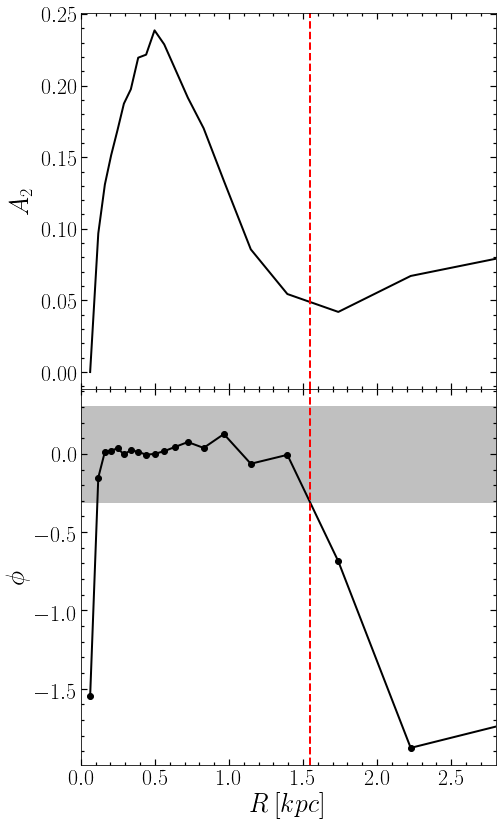

1.69543622736


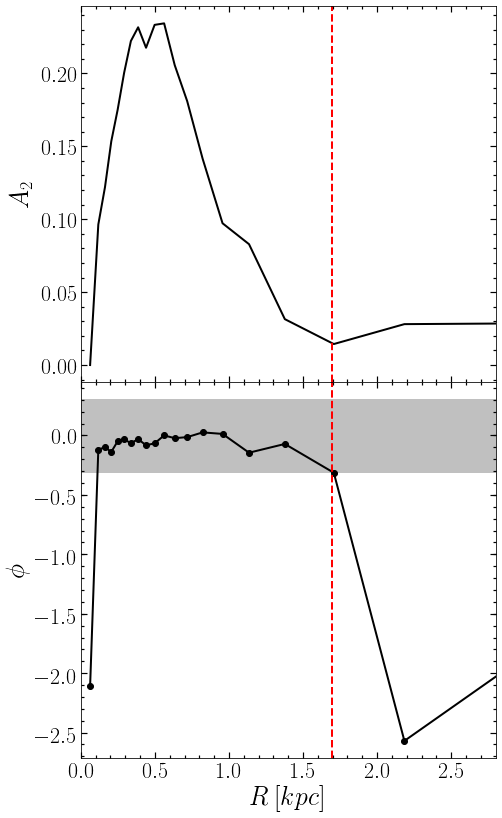

1.81040941374


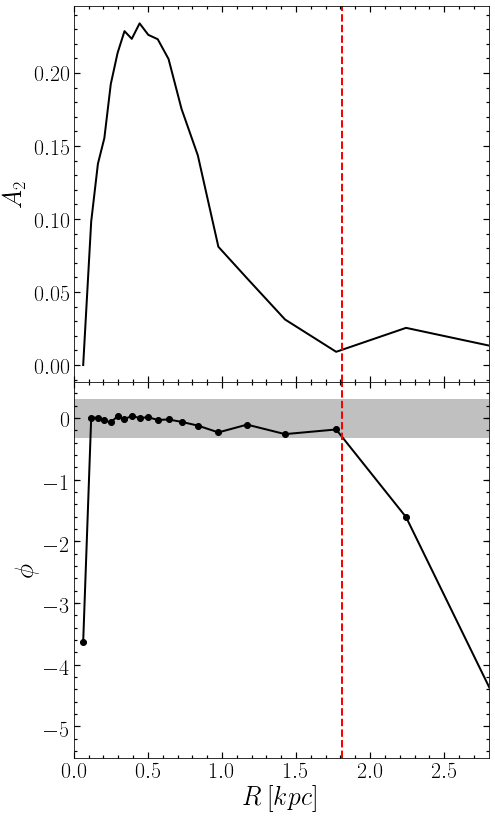

1.16994112948


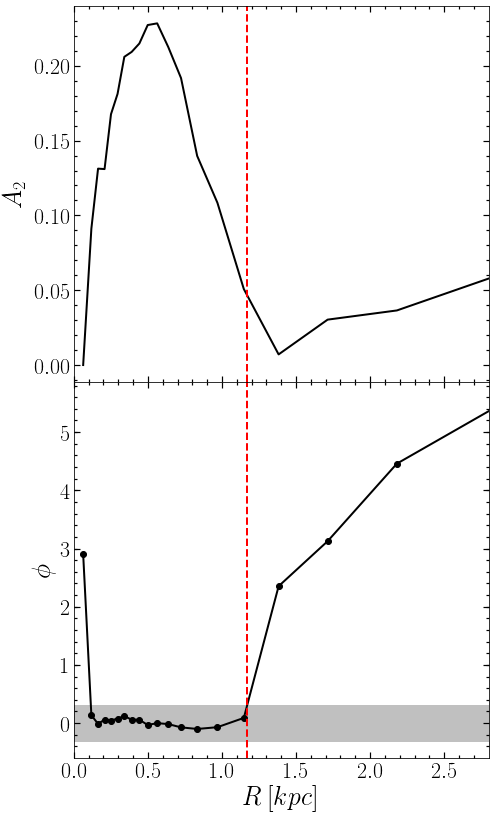

1.29821517202


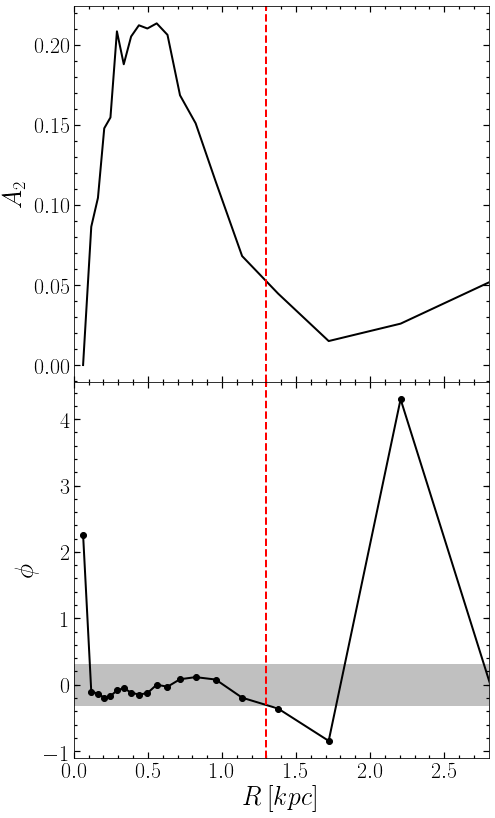

1.31628307758


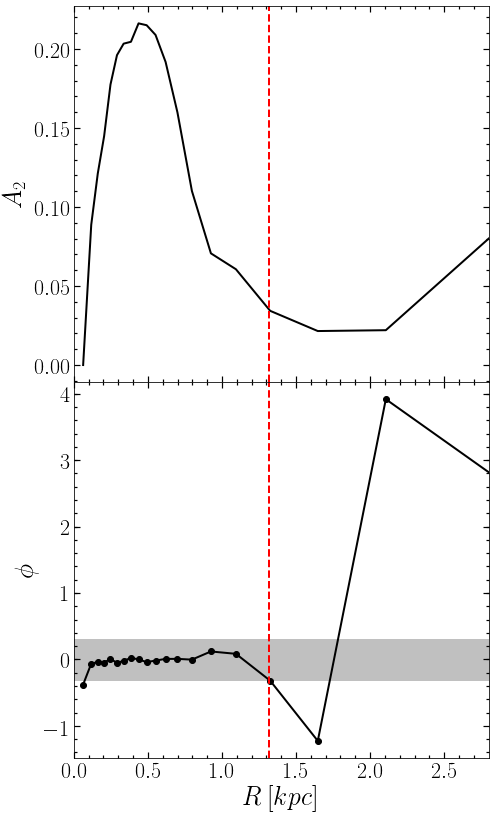

1.47717672487


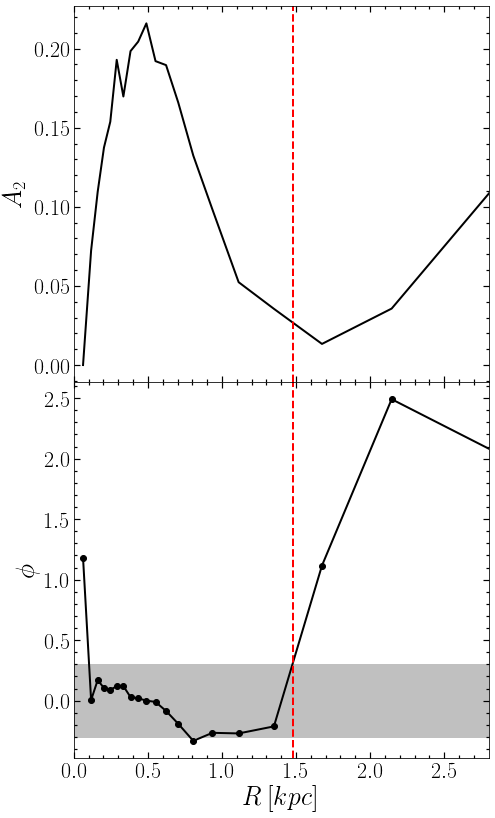

1.68415125609


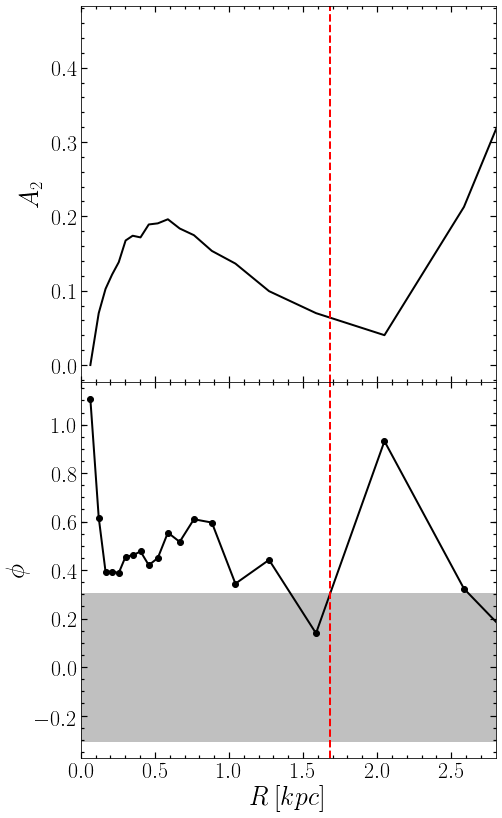

1.68415125609


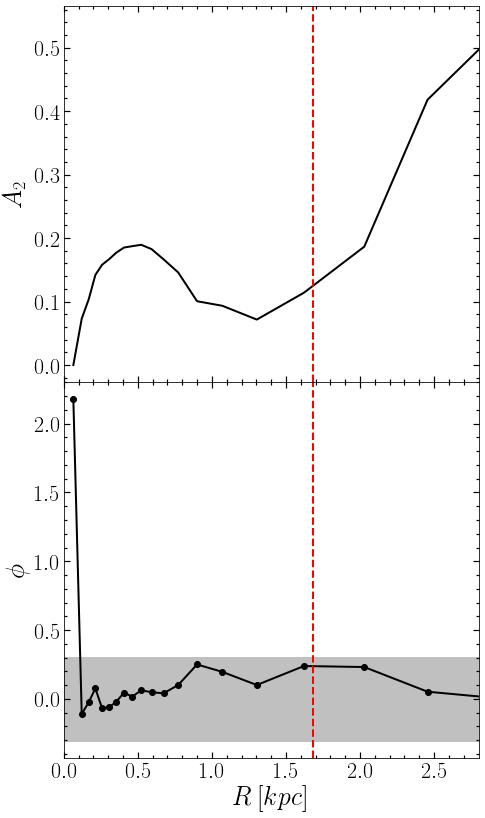

0.799379143452


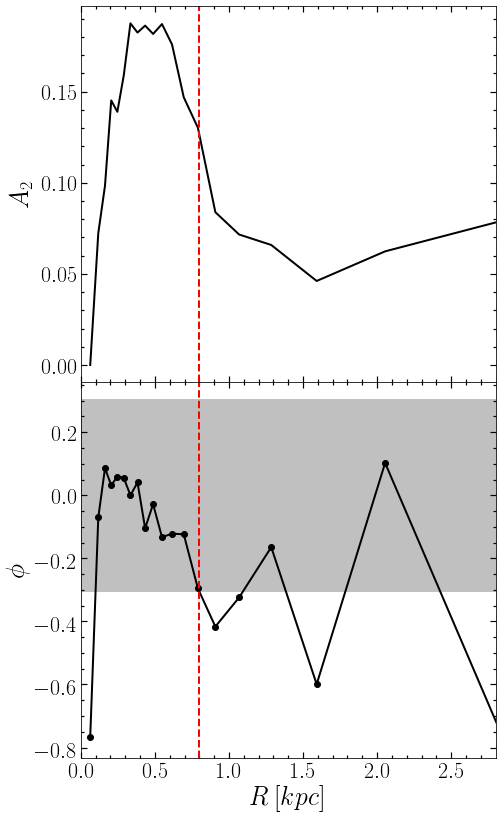

0.907822492306


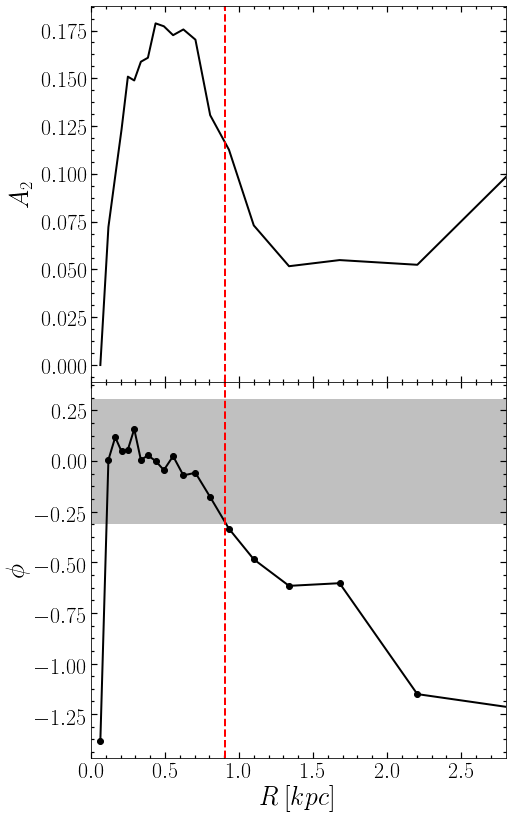

In [16]:
import h5py
import rotation as rot
import time_conversion as tiempo
import barstrength as strng
import matplotlib.gridspec as gridspec
from __future__ import unicode_literals

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True

#Parámetros cosmológicos
#--------------------------------------------------------------------------
h=0.732
G = 4.299e-6
a0=1.
H0 = h*100
omega_lambda=0.716
omega_matter=0.1277/(h**2.)
omega0 = omega_lambda + omega_matter
#---------------------------------------------------------------------------

aa = np.loadtxt('/home/ornela/python/ornella/redshift_outputs.txt')
aexp = aa[:,2]

snapshot=range(360,300,-1) #SNAPSHOTS

for isnap in snapshot:
    snap = h5py.File('/home/ornela/python/ornella/outputs_1/snap_'+str('%03d'%isnap)+'.h5py', 'r')

    cm   = snap['subhalo_000/Center'].value
    r200 = snap['subhalo_000/R200'].value
    pstr = snap['subhalo_000/Str/Coordinates'].value
    mstr = snap['subhalo_000/Str/Masses'].value
    vel  = snap['subhalo_000/Str/Velocities'].value
  
    z     = a0/aexp[isnap] - 1.
    Ht    = H0*np.sqrt(omega_lambda+(1-omega0)*(1+z)**2+omega_matter*(1+z)**3)
    time  = tiempo.conv(z, h, omega_lambda, omega_matter)

#paso las coordenadas al centro de la galaxia y paso a coordenadas físicas
    xstr = (pstr[:,0]-cm[0])*aexp[isnap]/h
    ystr = (pstr[:,1]-cm[1])*aexp[isnap]/h
    zstr = (pstr[:,2]-cm[2])*aexp[isnap]/h
    r    = np.sqrt(xstr**2+ystr**2+zstr**2)
    
#paso las velocidades a unidades físicas
    v_x = vel[:,0] *np.sqrt(aexp[isnap]) + Ht *xstr/1000.
    v_y = vel[:,1] *np.sqrt(aexp[isnap]) + Ht *ystr/1000.
    v_z = vel[:,2] *np.sqrt(aexp[isnap]) + Ht *zstr/1000.

    mstr = mstr/h     #masa a unidades físicas

    r200 = r200*aexp[isnap]/h #radio virial a unidades fisicas

    rgal = 0.15*r200          #defino el radio de la galaxia
#     print 'rgal=', rgal
    
    limit = np.where(r<rgal)         #hago un límite de los r dentro de rgal
    r_sort = np.sort(r[limit])       #acomodo los r de menor a mayor
    r_indice = np.argsort(r[limit])  #saco los argumentos de r acomodados de menor a mayor

    Mc_str = cumsum(mstr[limit][r_indice])  #masa acumulada en cada radio dentro de rgal
    Mgal = Mc_str[-1]  #masa total de la galaxia

#Calculo de los radios a 50% y 90% la masa de la galaxia
#-----------------------------------------------------------------------
    razon = Mc_str/Mgal 
    noventa, = np.where(razon < 0.9)
    cincuenta, = np.where(razon < 0.5)

    r90 = r_sort[noventa][-1]   #radio a 90% la masa
    r50 = r_sort[cincuenta][-1] #radio a 50% la masa
    
#     print 'r50=', r50
#     print 'r90=', r90
#     print r'log(M+/Msol)=', log10(Mgal*1e10)

#componentes de la velocidad del centro de masa
    veloc, = np.where(r < r50)
    
    vxcm = sum(mstr[veloc]*v_x[veloc])/sum(mstr[veloc])
    vycm = sum(mstr[veloc]*v_y[veloc])/sum(mstr[veloc])
    vzcm = sum(mstr[veloc]*v_z[veloc])/sum(mstr[veloc])

#velocidades de las estrellas respecto del centro de masa de la galaxia
    vx = v_x - vxcm
    vy = v_y - vycm
    vz = v_z - vzcm


#calculo el raux
#     raux = 2*r50
#------------------------------------------------------------------------------------
    dd = range(496,300,-1)
    dd.remove(428)
    if isnap in dd:
        raux = 2*r50
    elif (isnap == 428) or ((isnap < 301) & (isnap > 283)):
        raux = r50
    elif (isnap > 271) & (isnap < 284):
        raux = 0.75
    elif isnap < 272:
        raux = 0.5
#-----------------------------------------------------------------------------------

#hago la rotación de las coordenadas respecto del momento angular    
    e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(mstr,xstr,ystr,zstr,vx,vy,vz,raux)

    xn = e1x*xstr + e1y*ystr + e1z*zstr
    yn = e2x*xstr + e2y*ystr + e2z*zstr
    zn = e3x*xstr + e3y*ystr + e3z*zstr
    vxn = e1x*vx + e1y*vy + e1z*vz
    vyn = e2x*vx + e2y*vy + e2z*vz
    vzn = e3x*vx + e3y*vy + e3z*vz
    
    
    corte1,=np.where(r<rgal)
    
#     if isnap in range(256,272):
#         corte2 = np.where(r<0.75)
#     else:
#         corte2 = np.where(r<raux)

    corte1, = np.where(r<4*r50)
    corte2, = np.where(r<raux)
    corte3, = np.where(r<2*r50)

    A2, phi, rbin = strng.a2(mstr[corte1], xn[corte1], yn[corte1], 20)
    A2max, rmax, phimax = strng.a2max(mstr[corte1], xn[corte1], yn[corte1], 20)

    
# med = mean(phi[1:5])

    phii = phi - phimax


    for i in range(1,len(phii)-2):
        if ((phii[i]<np.arcsin(0.3)) & (phii[i]>-np.arcsin(0.3)) & (phii[i+1]>np.arcsin(0.3))):
            if ((phii[i+2]>np.arcsin(0.3)) | (phii[i+2]<-np.arcsin(0.3))):
                pend = (phii[i+1]-phii[i])/(rbin[i+1]-rbin[i])
                ordenada = phii[i]- pend*rbin[i]
                lbar = (np.arcsin(0.3) - ordenada)/pend
                break
        elif ((phii[i]>-np.arcsin(0.3)) & (phii[i]<np.arcsin(0.3)) & (phii[i+1]<-np.arcsin(0.3))):
            if ((phii[i+2]>np.arcsin(0.3)) | (phii[i+2]<-np.arcsin(0.3))):
                pend = (phii[i+1]-phii[i])/(rbin[i+1]-rbin[i])
                ordenada = phii[i]- pend*rbin[i]
                lbar = (-np.arcsin(0.3) - ordenada)/pend
                break
    print lbar


# fig, (ax1, ax)=plt.subplots(2, sharex=True, figsize=(8,8))
    fig=plt.figure(1,figsize=(8,12))
    fig.subplots_adjust(bottom=0.08, left =0.2, right = 0.92, top = 0.95, wspace=0.03, hspace= 0)
    ax1=fig.add_subplot(211)
    ax1.plot(rbin,A2,'-', lw=2, color='k')
    ax1.set_xlim(0.0,2.8)

    # ax.set_xlim(2,14)
    # ax.set_ylim(0.,0.5)
    # ax.spines['bottom'].set_color('w')
    # ax.spines['top'].set_color('w')
    # ax.spines['left'].set_color('w')
    # ax.spines['right'].set_color('w')
    ax1.set_xticklabels([])
    ax1.minorticks_on()
    ax1.tick_params( labelsize=22) #colors='lightgray')
    ax1.tick_params('both', length=3, width=1.2, which='minor', direction='in', right='on',top='on')#,colors='w')
    ax1.tick_params('both', length=6, width=1.2, which='major', direction='in', right='on',top='on')#,colors='w')  
    ax1.axvline(x=lbar, color='r', lw=2, ls='--')
    # ax.set_facecolor('silver')
    # ax.grid(color='w',linestyle=':',which='major')
    #ax.grid(color='lightgray',linestyle=':',which='minor')
    # ax1.set_xlabel(r'$R$ $[kpc]$', fontsize=26 )#, color='lightgray')
    ax1.set_ylabel(r'$A_{2}$',fontsize=26)#, color='lightgray')

    ax=fig.add_subplot(212)
    ax.fill_between([rbin[0]-0.5,rbin[-1]+0.5],np.arcsin(0.3),-np.arcsin(0.3), color='silver')
    ax.plot(rbin,phii,'ko-', lw=2, color = 'k')
    # ax.set_ylim(0,0.5)
    ax.set_xlim(0,2.8)
    #ax.set_title('subhalo_0'+ str('%s'%vector[i]), fontsize=24)
    # ax.spines['bottom'].set_color('w')
    # ax.spines['top'].set_color('w')
    # ax.spines['left'].set_color('w')
    # ax.spines['right'].set_color('w')
    ax.minorticks_on()
    ax.tick_params( labelsize=22)#, colors='w')
    ax.tick_params('both', length=3, width=1.2,which='minor', direction='in', right='on',top='on')#,colors='w')
    ax.tick_params('both', length=6, width=1.2,which='major', direction='in', right='on',top='on')#,colors='w')  
    # ax.set_facecolor('silver')
    # ax.grid(color='w',linestyle=':',which='major')
    #ax.grid(color='lightgray',linestyle=':',which='minor')
    ax.set_xlabel(r'$R\:[kpc]$', fontsize=26)#, color='w')
    ax.set_ylabel(r'$\phi$',fontsize=26)#, color='w')
    ax.axvline(x=lbar, color='r', lw=2, ls='--')
    # ax.axhline(y=np.arcsin(0.3), color='r', lw=2, ls='--')
    # ax.axhline(y=-np.arcsin(0.3), color='r', lw=2, ls='--')
    # ax.axvline(x=rmax, color='b', lw=2, ls='--')
    # ax.axhline(y=A2max, color='b', lw=2, ls='--')
    #     plt.text(x = 2, y = 0.43, 
    #              s =r'$R_{max}=$' +str('%.3f'%rmax)+', $A_{2}^{max}=$' + str('%.3f'%A2max),
    #              fontsize = 20, va= 'center', ha= 'left', color = 'k')
    #     plt.annotate('$l_{bar} =$'+ '%.2f'%lbar, xy=(lbar,0), xytext=(0, +80), textcoords='offset points', 
    #                          fontsize=22,arrowprops=dict(facecolor='black', shrink=0.02, lw=0.1),ha="center")

    plt.show()



## Rcorot y Lbar en funcion del tiempo

In [39]:
import matplotlib.pyplot as plt
import h5py
import rotation as rot
import sphviewer as sph
import numpy as np
import time_conversion as tiempo

h=0.732
a0=1
omega_lambda=0.716
omega_matter=0.1277/(h**2.)
G = 4.299e-6

aa = np.loadtxt('/home/ornela/python/ornella/redshift_outputs.txt')
aexp = aa[:,2]

#fo =open('/home/ornela/python/fdisc.dat','a')

snapshot=range(309,308,-1)
for isnap in snapshot:

    snap = h5py.File('/home/ornela/python/ornella/outputs_1/snap_'+str('%03d'%isnap)+'.h5py', 'r')

    pstr = snap['subhalo_000/Str/Coordinates'].value
    cm   = snap['subhalo_000/Center'].value
    vel  = snap['subhalo_000/Str/Velocities'].value
    masa_str = snap['subhalo_000/Str/Masses'].value
    r200 = snap['subhalo_000/R200'].value

    pgas = snap['subhalo_000/Gas/Coordinates'].value
    masa_gas = snap['subhalo_000/Gas/Masses'].value

    pdrk = snap['subhalo_000/Drk/Coordinates'].value
    masa_drk = snap['subhalo_000/Drk/Masses'].value
        
#-------------paso las coordenadas respecto al centro de la galaxia------------------
    xstr = (pstr[:,0]-cm[0])*aexp[isnap]/h
    ystr = (pstr[:,1]-cm[1])*aexp[isnap]/h
    zstr = (pstr[:,2]-cm[2])*aexp[isnap]/h
    r = np.sqrt(xstr**2+ystr**2+zstr**2)

    xgas = (pgas[:,0]-cm[0])*aexp[isnap]/h
    ygas = (pgas[:,1]-cm[1])*aexp[isnap]/h
    zgas = (pgas[:,2]-cm[2])*aexp[isnap]/h
    rgas = np.sqrt(xgas**2+ygas**2+zgas**2)

    xdrk = (pdrk[:,0]-cm[0])*aexp[isnap]/h
    ydrk = (pdrk[:,1]-cm[1])*aexp[isnap]/h
    zdrk = (pdrk[:,2]-cm[2])*aexp[isnap]/h
    rdrk = np.sqrt(xdrk**2+ydrk**2+zdrk**2)

#---------------masas------------------------------------
    masa_str = masa_str/h
    masa_gas = masa_gas/h
    masa_drk = masa_drk/h

    r200 = r200*aexp[isnap]/h
    rgal=0.15*r200

    limit = np.where(r<rgal)
    r_sort = np.sort(r[limit])
    r_indice = np.argsort(r[limit])

    Mc_str = cumsum((masa_str[limit])[r_indice])

#----------------------calculamos r50---------------------------    
    M_gal = Mc_str[-1]

    razon = Mgal_str/M_gal
    noventa, = np.where(razon < 0.9)
    cincuenta, = np.where(razon < 0.5)

    r90 = r_sort[noventa]
    r50 = r_sort[cincuenta]

#----------calculamos la masa total----------------------
    rtot= concatenate([r,rgas,rdrk])
    mtot= concatenate([masa_str, masa_gas, masa_drk])

    limit_tot = np.where(rtot<r200)
    rtot_sort = np.sort(rtot[limit_tot])
    rtot_indice = np.argsort(rtot[limit_tot])

    Mc_tot = cumsum((mtot[limit_tot])[rtot_indice])
    M_total = Mc_tot*1e10

#-------------calculamos la velocidad maxima a r50 y Vstr---------------------
    V50 = np.sqrt((G*M_total[cincuenta])/rtot_sort[cincuenta])
    V_50 = V50[-1]
    Vdisc = np.sqrt((G*Mc_str[-1]*1e10)/r50[-1])
    
    Vtot = np.sqrt((G*Mc_tot*1e10)/rtot_sort)
    Vmax = max(Vtot)
#------------calculamos el parametro de inestabilidad del disco----------------
    fdisc = V_50/Vdisc
    
    print 'f_disc=', fdisc
    
    fdec = V_50/Vmax
    
    print 'f_dec=', fdec

#     fo.write(str('%.6f'% t) +'\t'+
#              str('%12.6f'% epsilon) +'\n')
#     fo.close()
        
        

f_disc= 0.890701305895
f_dec= 0.981484
